# 5장. Working Area Validation

이전 챕터에서 우리가 조사한 Working Area 의 max, min HSV 값을 이용해서 카메라로 촬영한 frame 에서 색상을 찾습니다.  
노이즈 제거 작업과 함께, 찾은 영역의 윤곽선을 따서, 윤곽선이 있는 지 없는 지 여부로 해당 Working Area 에 대한 HSV 값의 유효성을 판별합니다.  
만약, 검증이 되지 않는다면, 다시 Inspection 노트북을 실행해서 해당 Working Area 에 대한 HSV 값 조사를 재실시 합니다.  

검증 기준은 다음과 같습니다.
1. 테스트하고자 하는 색상 영역이 보이면 인식할 수 있는가
2. 테스트하는 색상 이외에 영역에서는 인식이 되지 않는가

인공지능 무인운반차량(AGV)는 수동으로 제어할 수 있습니다.

## 라이브러리 가져오기

In [1]:
from IPython.display import display
import ipywidgets
import ipywidgets.widgets as widgets
import traitlets
from robotpal import Robot, Camera, bgr8_to_jpeg
from robotpal.SCSCtrl import TTLServo

import threading
import cv2
import numpy as np
import time

[RobotPal] 서버 시작됨 | WebSocket: 9999, TCP: 9998
[RobotPal] 통신 대기 중... (WS: 9999, TCP: 9998)


[System] WebSocket 프로세서 시작


## 카메라, 로봇 객체 초기화하기

In [ ]:
robot = Robot()
camera = Camera()

TTLServo.servoAngleCtrl(5, 45, 1, 100)


# 최대, 최소 HSV 값 표시하는 레이블 생성
lbl1 = ipywidgets.Label(value="Max :")
colorlblMax = ipywidgets.Label(value="0")
hbox1 = widgets.HBox([lbl1, colorlblMax] )

lbl2 = ipywidgets.Label(value="Min :")
colorlblMin = ipywidgets.Label(value="0")
hbox2 = widgets.HBox([lbl2, colorlblMin])

lbl3 = ipywidgets.Label(value="Color :")
colorlbl = ipywidgets.Label(value="None")
hbox3 = widgets.HBox([lbl3, colorlbl])

image_widget = ipywidgets.Image(format='jpeg', width=224, height=224)
vbox1 = widgets.VBox([hbox1, hbox2, hbox3,image_widget])

#수동 조작용 버튼 생성
lbl4 = ipywidgets.Label(value="Manual Controller")
button_layout = widgets.Layout(width='100px', height='80px', align_self='center')
stop_button = widgets.Button(description='stop', button_style='danger', layout=button_layout)
forward_button = widgets.Button(description='forward', layout=button_layout)
backward_button = widgets.Button(description='backward', layout=button_layout)
left_button = widgets.Button(description='left', layout=button_layout)
right_button = widgets.Button(description='right', layout=button_layout)

middle_box = widgets.HBox([left_button, stop_button, right_button], layout=widgets.Layout(align_self='center'))
controls_box = widgets.VBox([lbl4,forward_button, middle_box, backward_button])
hbox4 = widgets.HBox([vbox1, controls_box])
display(hbox4)

manual_btnlst = [stop_button, forward_button, backward_button, left_button, right_button]
camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)

def stop(change):
    robot.stop()
    
def step_forward(change):
    robot.forward(0.4)

def step_backward(change):
    robot.backward(0.4)

def step_left(change):
    robot.left(0.3)
    time.sleep(0.5)
    robot.stop()

def step_right(change):
    robot.right(0.3)
    time.sleep(0.5)
    robot.stop()

stop_button.on_click(stop)
forward_button.on_click(step_forward)
backward_button.on_click(step_backward)
left_button.on_click(step_left)
right_button.on_click(step_right)

# 검증할 색상의 index
test_num = 5

# 조사한 색상의 이름과 min, max HSV 값을 담은 리스트
colors = [
        {'name': 'red', 'lower': np.array([3, 217, 214]), 'upper': np.array([4, 222, 218]) }, # o
        {'name': 'mint', 'lower': np.array([68, 17, 221]), 'upper': np.array([70, 20, 222]) }, # o
        {'name': 'blue', 'lower': np.array([106, 212, 207]), 'upper': np.array([108, 223, 216]) }, # o 
        {'name': 'darkblue', 'lower':  np.array([120, 201, 182]), 'upper': np.array([120, 206, 189]) }, # o
        {'name': 'yellow', 'lower': np.array([27, 85, 195]), 'upper': np.array([30, 97, 221]) },
        {'name': 'orange', 'lower': np.array([17, 145, 222]), 'upper': np.array([18, 154, 224]) }
    ]

# 카메라로 촬영한 frame 크기
frame_width = 224
frame_height = 224

# 카메라로 촬영한 frame 중심 좌표
camera_center_X = int(frame_width/2)
camera_center_Y = int(frame_height/2)

# HSV 값을 담아줄 리스트
colorHSVvalueList = []

# 최대 측정할 개수
max_len = 20

## WorkingAreaFind() 클래스 생성

In [3]:
# 유효성 검증을 할 클래스 생성
class WorkingAreaFind(threading.Thread):
    def __init__(self):
        super().__init__()
        self.th_flag=True
        self.imageInput = 0
        
    def run(self):
        while self.th_flag:
            self.imageInput = camera.value
            hsv = cv2.cvtColor(self.imageInput, cv2.COLOR_BGR2HSV)

            #blur
            hsv = cv2.blur(hsv, (15, 15))
    
            #색깔인식 테스트용 코드
            self.colorRecog(hsv)

            # target 색상과 일치하는 픽셀에 대한 mask 생성
            mask = cv2.inRange(hsv, colors[test_num]['lower'], colors[test_num]['upper'])
            
            # 노이즈 제거를 위해 erode 실행
            mask = cv2.erode(mask, None, iterations=2)
            mask = cv2.dilate(mask, None, iterations=2)

            # 해당 영역에 대한 윤곽선 따기
            Contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 해당 영역에 대한 윤곽선이 존재한다면, 영역을 발견했다면
            if Contours:
                self.colorAction(test_num, Contours)
            # Working Area 를 못 찾았다면
            else:
                colorlbl.value = "None"
            image_widget.value = bgr8_to_jpeg(self.imageInput)
            time.sleep(0.1)
    
    
    def colorAction(self, test_num, Contours):
        # 검증된 Working Area 의 이름을 레이블에 표시
        colorlbl.value = colors[test_num]['name']
        
        # 찾은 영역 중 가장 큰 영역 찾기
        c = max(Contours, key=cv2.contourArea)
        # 가장 큰 영역에 내접하는 원을 그려 중심 점과 반지름 구하기
        ((box_x, box_y), radius) = cv2.minEnclosingCircle(c)

        X = int(box_x)
        Y = int(box_y)
        
        # 카메라 중심 pixel 로부터 찾은 Working Area의 중심 사이 떨어진 거리
        error_Y = abs(camera_center_Y - Y)
        error_X = abs(camera_center_X - X)
        
        #rectangle(leftX,upY, rightX,downY)
        cv2.rectangle(self.imageInput,(int(box_x-radius),int(box_y+radius)),(int(box_x+radius),int(box_y-radius)),(255,255,255),1)
        cv2.putText(self.imageInput,f'error_X:{ error_X }',(X-30,Y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)

    # WorkingArea 인식용 클래스
    def colorRecog(self, hsv):
        # Center Pixel 의 hsv 값 읽어오기
        hsvValue = hsv[int(frame_height/2), int(frame_width/2)]
        
        # data 20개 모아서, 최대, 최소 값 구하기
        colorHSVvalueList.append(hsvValue)
        if len(colorHSVvalueList) > max_len:
            del colorHSVvalueList[0]
            
        max_h,max_s,max_v = np.maximum.reduce(colorHSVvalueList)
        min_h,min_s,min_v = np.minimum.reduce(colorHSVvalueList)

        # Center Pixel 주위에 20x20 크기의 사각형 그리기
        rect_s = 20
        cv2.rectangle(self.imageInput,
                      (int(frame_width/2)-int(rect_s/2),int(frame_height/2)-int(rect_s/2)),
                      (int(frame_width/2)+int(rect_s/2),int(frame_height/2)+int(rect_s/2)),
                      (0,0,255),1)
        
        #max , min value 표시
        cv2.putText(self.imageInput,f'max_HSV:{ max_h,max_s,max_v }',(20,180), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,255),1,cv2.LINE_AA)
        cv2.putText(self.imageInput,f'min_HSV:{ min_h,min_s,min_v }',(20,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
        colorlblMax.value = str(max_h)+","+ str(max_s)+","+ str(max_v)
        colorlblMin.value = str(min_h)+","+ str(min_s)+","+ str(min_v)
        
    def stop(self):
        self.th_flag = False
        robot.stop()
        
AreaFinding = WorkingAreaFind()
AreaFinding.start()

실행 결과  
테스트 하는 색상은 이전 챕터에서 조사한 노란색이다.
1. 노란색 영역 인지하는 모습 ( 검증 1 통과 )  
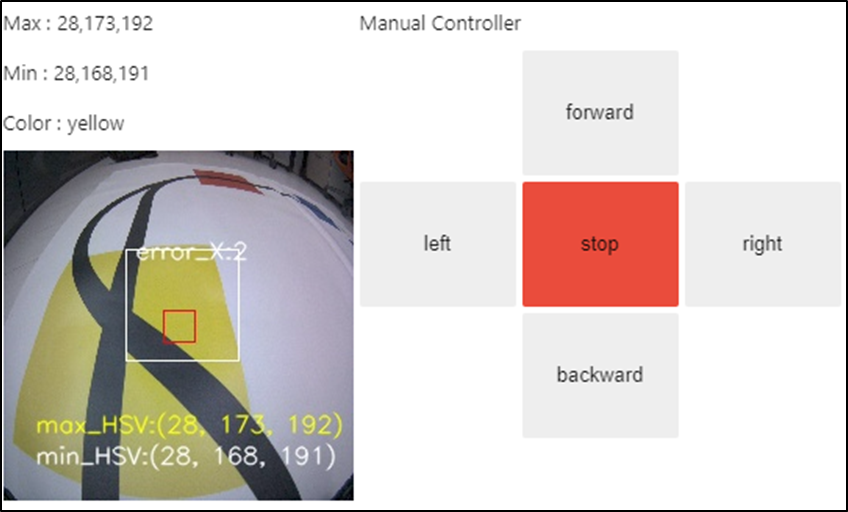

2.	다른 Working Area 에서 혼동하지 않는 모습 ( 검증 2 통과 )  
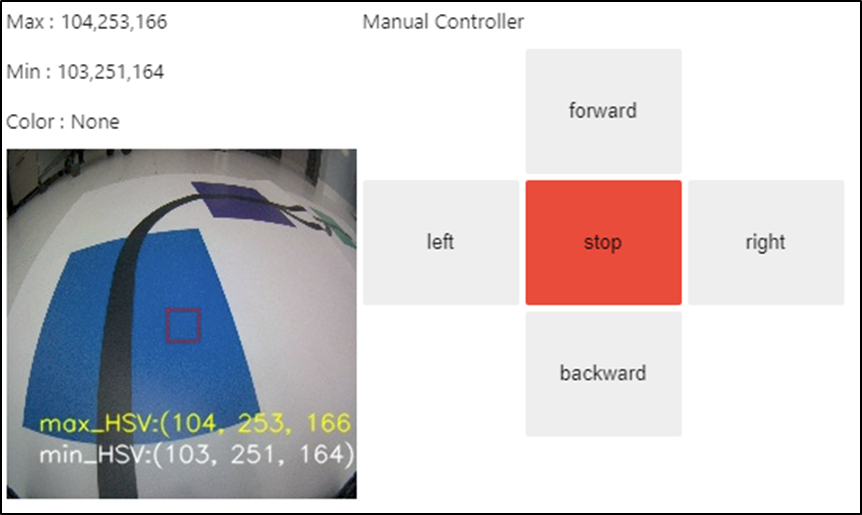

## 프로젝트 종료하기
아래 코드를 실행해서 프로젝트를 종료합니다.

In [12]:
AreaFinding.stop()
AreaFinding.join()
time.sleep(0.1)
robot.stop()
camera.stop()
print('End')

End


이제 다음 챕터에서는 Road Following 기능과 함께 Working Area Recognition 기능이 동작하는 지 테스트합니다.